# NEON RSDI 2018 Capstone Project
## Harvard Forest Species Identification

LaPHS = Lidar and PhenoCam Hyperspectral Synthesis 

* Christopher Kilner      christopher.kilner@duke.edu
* Adam Young              Adam.Young@nau.edu
* Victoria Scholl         victoria.scholl@colorado.edu
* Stephanie Auer          stephanie.auer@gmail.com
* Bijan Seyednasollah     bijan.s.nasr@gmail.com


July 13, 2018 NEON Data Institute

*If in other sciences, we should arrive at certainty without doubt and thruth without error, it behooves us to place the foundations of knowledge in Mathematics*

### Spectral Indices Calculations Notebook

In [1]:
#Install/Import necessary packages
import h5py
import numpy as np
import gdal
import os
import matplotlib.pyplot as plt
from math import floor
from copy import copy
import pandas
import warnings
warnings.filterwarnings('ignore')

In [2]:
def h5refl2array(h5_filename):
    hdf5_file = h5py.File(h5_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    refl = hdf5_file[sitename]['Reflectance']
    reflArray = refl['Reflectance_Data']
    refl_shape = reflArray.shape
    wavelengths = refl['Metadata']['Spectral_Data']['Wavelength']
    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['shape'] = reflArray.shape
    metadata['mapInfo'] = refl['Metadata']['Coordinate_System']['Map_Info']
    #Extract no data value & set no data value to NaN\n",
    metadata['scaleFactor'] = float(reflArray.attrs['Scale_Factor'])
    metadata['noDataVal'] = float(reflArray.attrs['Data_Ignore_Value'])
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['EPSG'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    mapInfo_string = str(mapInfo); #print('Map Info:',mapInfo_string)\n",
    mapInfo_split = mapInfo_string.split(",")
    #Extract the resolution & convert to floating decimal number
    metadata['res'] = {}
    metadata['res']['pixelWidth'] = mapInfo_split[5]
    metadata['res']['pixelHeight'] = mapInfo_split[6]
    #Extract the upper left-hand corner coordinates from mapInfo\n",
    xMin = float(mapInfo_split[3]) #convert from string to floating point number\n",
    yMax = float(mapInfo_split[4])
    #Calculate the xMax and yMin values from the dimensions\n",
    #xMax = left edge + (# of columns * resolution)\n",
    xMax = xMin + (refl_shape[1]*float(metadata['res']['pixelWidth'])) 
    #yMin = top edge - (# of rows * resolution)\n",
    yMin = yMax - (refl_shape[0]*float(metadata['res']['pixelHeight'])) 
    metadata['extent'] = (xMin,xMax,yMin,yMax),
    metadata['ext_dict'] = {}
    metadata['ext_dict']['xMin'] = xMin
    metadata['ext_dict']['xMax'] = xMax
    metadata['ext_dict']['yMin'] = yMin
    metadata['ext_dict']['yMax'] = yMax
    hdf5_file.close        
    return reflArray, metadata, wavelengths

#Raster to Array
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    
def h5_file_to_clean_raster(h5_file_path):
    #read the file as array and metadata
    siteRefl,siteMetadata,wavelengths=h5refl2array(h5_file_path)
    
    #filtering out band bands
    w = copy(siteMetadata['wavelength'])
    w[((w>=1340)&(w<=1445))|((w>=1790)&(w<=1955))]=np.nan
    w[-10:]=np.nan

    #Good Bands
    goodbands = np.concatenate(np.where(np.invert(np.isnan(w))))
    cleanRefl = siteRefl[:,:,goodbands]
    wavelengths =w[np.where(np.invert(np.isnan(w)))]
    return cleanRefl, siteMetadata, goodbands, wavelengths

In [3]:
#Read in and confirm through exploration the Clean Hyperspectral Data
h5_directory = '../data/'
all_files = os.listdir(h5_directory)
h5_files = [i for i in all_files if i.endswith('.h5')]
print(h5_files)

['NEON_D01_HARV_DP3_732000_4713000_reflectance.h5']


In [4]:
#Spectral Indice Definitions
wBlue = 470
wRed = 650
wGreen = 550
wNIR = 860
wPRI1 = 531
wPRI2 = 570
wLignin2 = 1754
wLigninNitro = 1680
wNitro1 = 1510
Gamma = 1

#For loop for multiple tiles
for f, file in enumerate(h5_files): 
    print('Working on ' + file)
    print('Counter (f): ' + str(f))

#Remove water vapor bad band windows & last 10 bands 
    reflArray, metadata, goodbands, wavelengths = h5_file_to_clean_raster(h5_directory + file)
    
    print('Calculating band indices...')
    Index_Blue = np.where(np.amin(np.abs(np.subtract(wavelengths,wBlue))) == (np.abs(np.subtract(wavelengths,wBlue))))[0][0]
    Index_Red = np.where(np.amin(np.abs(np.subtract(wavelengths,wRed))) == (np.abs(np.subtract(wavelengths,wRed))))[0][0]
    Index_Green = np.where(np.amin(np.abs(np.subtract(wavelengths,wGreen))) == (np.abs(np.subtract(wavelengths,wGreen))))[0][0]
    Index_NIR = np.where(np.amin(np.abs(np.subtract(wavelengths,wNIR))) == (np.abs(np.subtract(wavelengths,wNIR))))[0][0]
    Index_PRI1 = np.where(np.amin(np.abs(np.subtract(wavelengths,wPRI1))) == (np.abs(np.subtract(wavelengths,wPRI1))))[0][0]
    Index_PRI2 = np.where(np.amin(np.abs(np.subtract(wavelengths,wPRI2))) == (np.abs(np.subtract(wavelengths,wPRI2))))[0][0]
    Index_Lignin2 = np.where(np.amin(np.abs(np.subtract(wavelengths,wLignin2))) == (np.abs(np.subtract(wavelengths,wLignin2))))[0][0]
    Index_LigninNitro = np.where(np.amin(np.abs(np.subtract(wavelengths,wLigninNitro))) == (np.abs(np.subtract(wavelengths,wLigninNitro))))[0][0]
    Index_Nitro1 = np.where(np.amin(np.abs(np.subtract(wavelengths,wNitro1))) == (np.abs(np.subtract(wavelengths,wNitro1))))[0][0]
    
    Blue = reflArray[:,:,Index_Blue]
    Red = reflArray[:,:,Index_Red]
    Green = reflArray[:,:,Index_Green]
    NIR = reflArray[:,:,Index_NIR]
    PRI1 = reflArray[:,:,Index_PRI1]
    PRI2 = reflArray[:,:,Index_PRI2]
    Lignin2 = reflArray[:,:,Index_Lignin2]
    LigNitro = reflArray[:,:,Index_LigninNitro]
    Nitro1 = reflArray[:,:,Index_Nitro1]
    
    ENVI_Indices = np.zeros((reflArray.shape[0], reflArray.shape[1], 7))
    
    #Spectral Indice Calculations
    print('Calculating spectral indices...')
    ENVI_Indices[:,:,0] = np.divide(np.subtract(NIR, Red),np.add(NIR,Red))
    ENVI_Indices[:,:,1] = np.divide(np.multiply(2.5,np.subtract(NIR,Red)),np.subtract(np.add(NIR,np.multiply(6,Red)),np.add(np.multiply(7,Blue),1)))
    ENVI_Indices[:,:,2] = np.divide(np.subtract(NIR,np.subtract(Red,np.multiply(Gamma,np.subtract(Blue,Red)))),np.add(NIR,np.subtract(Red,np.multiply(Gamma,(np.subtract(Blue,Red))))))
    ENVI_Indices[:,:,3] = np.divide(np.subtract(PRI1,PRI2),np.add(PRI1,PRI2))
    ENVI_Indices[:,:,4] = np.divide(np.subtract(np.log(np.divide(1,Lignin2)),np.log(np.divide(1,LigNitro))),np.add(np.log(np.divide(1,Lignin2)),np.log(np.divide(1,LigNitro))))
    ENVI_Indices[:,:,5] = np.divide(np.subtract(np.log(np.divide(1,Nitro1)),np.log(np.divide(1,LigNitro))),np.add(np.log(np.divide(1,Nitro1)),np.log(np.divide(1,LigNitro))))
    ENVI_Indices[:,:,6] = np.divide(np.multiply(1.5,np.subtract(NIR,Red)),np.add(np.add(NIR,Red),0.5))
    
    xMin = metadata['ext_dict']['xMin']
    yMax = metadata['ext_dict']['yMax']
    EPSG = metadata['EPSG']
    
    #array2raster('../Data/ENVI_Index_'+filename_split[5]+'.tif',(xMin,yMax),1,-1,np.array(ENVI_Indices,dtype=float),EPSG)
    #array2raster('../Data/Clean'+filename_split[5]+'.tif',(xMin,yMax),1,-1,np.array(cleanRefl,dtype=float),EPSG)

Working on NEON_D01_HARV_DP3_732000_4713000_reflectance.h5
Counter (f): 0
Calculating band indices...
Calculating spectral indices...


In [5]:
print('Dimensions of Spectral Index Array:',ENVI_Indices.shape)

Dimensions of Spectral Index Array: (1000, 1000, 7)


In [6]:
print('Dimensions of Hyperspectral Array:',reflArray.shape)

Dimensions of Hyperspectral Array: (1000, 1000, 362)


### Woody Vegetation Locations

In [110]:
import sys
sys.version

'3.6.5 |Anaconda, Inc.| (default, Apr 26 2018, 08:42:37) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [111]:
import gdal, osr
import pandas
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
%matplotlib inline

In [112]:
#Import biomass specific libraries
from skimage.morphology import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from sklearn.ensemble import RandomForestRegressor

In [113]:
from sklearn.externals.six.moves import zip

import matplotlib.pyplot as plt

from sklearn.datasets import make_gaussian_quantiles
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

In [114]:
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]

    metadata['extent'] = (xMin,xMax,yMin,yMax)

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        #array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']

    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
            #band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

In [115]:
# read CHM tile
tile_1_name = '../data/NEON_D01_HARV_DP3_731000_4713000_CHM.tif'
tile_1_array, tile_1_metadata = raster2array(tile_1_name)
tile_1_array

array([[21.45999908, 21.10000038, 21.54000092, ..., 22.37000084,
        21.90999985, 21.68000031],
       [20.81999969, 19.65999985, 19.87999916, ..., 22.40999985,
        22.12000084, 21.46999931],
       [19.03000069, 19.36000061, 19.62000084, ..., 21.82999992,
        22.51000023, 21.37000084],
       ...,
       [21.51000023, 21.51000023, 21.67000008, ..., 21.64999962,
        21.63999939, 22.13999939],
       [21.07999992, 21.43000031, 21.22999954, ..., 22.17000008,
        22.70000076, 22.62000084],
       [22.01000023, 21.32999992, 21.51000023, ..., 21.37000084,
        21.85000038, 22.64999962]])

In [116]:
# Read in CSV file to find corresponding pixel values with individual tree locations
woodyveg_csv_name = '../output/NEON_D01_HARV_DP3_woody-veg-locations.csv'

In [117]:
woodyveg_pointloc_values = pd.read_csv(woodyveg_csv_name,delimiter=',')
xval=woodyveg_pointloc_values.easting
yval=woodyveg_pointloc_values.northing
woodyveg_pointloc_values[1:6]

,Unnamed: 0,individualID,scientificName,taxonID,easting,northing
1,2274,NEON.PLA.D01.HARV.00375,Tsuga canadensis (L.) Carrière,TSCA,731635.351825,4.713163e+06
2,2212,NEON.PLA.D01.HARV.00379,Tsuga canadensis (L.) Carrière,TSCA,731632.201610,4.713171e+06
3,2216,NEON.PLA.D01.HARV.00369,Betula lenta L.,BELE,731629.244839,4.713172e+06
4,2244,NEON.PLA.D01.HARV.00370,Tsuga canadensis (L.) Carrière,TSCA,731627.578518,4.713175e+06
5,2383,NEON.PLA.D01.HARV.00371,Betula lenta L.,BELE,731632.311190,4.713177e+06


In [118]:
# Create meshgrid to find pixel values
extent = tile_1_metadata['extent']
xMin = extent[0]; xMax = extent[1]; yMin = extent[2]; yMax = extent[3]
nx, ny = (tile_1_array.shape[1],tile_1_array.shape[0])
x = np.linspace(xMin+0.5,xMax-0.5,nx)
y = np.linspace(yMax-0.5,yMin+0.5,ny)
X,Y = np.meshgrid(x,y)

In [119]:
locs_in_array = (((xval>xMin)&(xval<xMax))&((yval<yMax)&(yval>yMin)))
nlocs = np.sum(locs_in_array)
x_val_in = np.asarray(xval[locs_in_array])
y_val_in = np.asarray(yval[locs_in_array])

In [120]:
pixloc_bool = np.zeros(tile_1_array.shape,dtype=bool)
response = woodyveg_pointloc_values.taxonID[locs_in_array]
for i in range(0,len(x_val_in)-1):
    
    xDiff = np.abs(np.subtract(x_val_in[i],X))
    yDiff = np.abs(np.subtract(y_val_in[i],Y))
    
    xDiff_idx = (xDiff == np.min(xDiff))
    yDiff_idx = (yDiff == np.min(yDiff))
    
    pixloc_bool_i = np.multiply(xDiff_idx,yDiff_idx)
    pixloc_bool   = pixloc_bool + pixloc_bool_i
    
    response
    #pixloc_idx = np.where(pixloc_bool==True)
    
    #array_index[i,:] = pixloc_idx

(1387,)

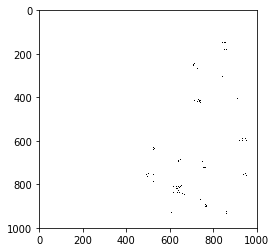

In [121]:
plt.imshow(pixloc_bool)

### Principal Component Analysis

Many of the bands within hyperspectral images are often strongly correlated so we want to reduce the dimensionality of reflectance before we put it in the classification model.

The principal components transformation represents a linear transformation of the original image bands to a set of new, uncorrelated features. These new features correspond to the eigenvectors of the image covariance matrix, where the associated eigenvalue represents the variance in the direction of the eigenvector. A very large percentage of the image variance can be captured in a relatively small number of principal components (compared to the original number of bands).

In [19]:
!{sys.executable} -m pip install '../pysptools-0.14.2.tar.gz'

Processing /Users/victoriascholl/github/Laphs/pysptools-0.14.2.tar.gz
  Running setup.py bdist_wheel for pysptools ... done
  Stored in directory: /Users/victoriascholl/Library/Caches/pip/wheels/80/71/8a/2735fa2fe2be1693ea3b670b3ab887e254c25adf496983ce17
Successfully built pysptools


In [20]:
import h5py, os, copy
import matplotlib.pyplot as plt
import numpy as np
import pysptools.util as util
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
import pysptools.material_count as cnt

from spectral import *
import spectral.io.envi as envi
import matplotlib.pyplot as plt
#from matplotlib.mlab import PCA
#from sklearn.preprocessing import Imputer
#from sklearn.decomposition import PCA
import gdal
import pandas as pd

%matplotlib inline

#for clean output, to not print warnings, don't use when developing script
import warnings
warnings.filterwarnings('ignore')

In [21]:
def read_neon_reflh5(refl_filename):
    """read in a NEON AOP reflectance hdf5 file and returns 
    reflectance array, and metadata dictionary containing metadata 
    (similar to envi header format)
    --------
    Parameters
        refl_filename -- full or relative path and name of reflectance hdf5 file
    --------
    Returns 
    --------
    reflArray:
        array of reflectance values
    metadata:
        dictionary containing the following metadata (all strings):
            bad_band_window1: min and max wavelenths of first water vapor window (tuple)
            bad_band_window2: min and max wavelenths of second water vapor window (tuple)
            bands: # of bands (float)
            coordinate system string: coordinate system information (string)
            data ignore value: value corresponding to no data (float)
            interleave: 'BSQ' (string)
            reflectance scale factor: factor by which reflectance is scaled (float)
            wavelength: wavelength values (float)
            wavelength unit: 'm' (string)
            spatial extent: extent of tile [xMin, xMax, yMin, yMax], UTM meters
    --------
    Example Execution:
    --------
    sercRefl, sercMetadata = h5refl2array('NEON_D02_SERC_DP1_20160807_160559_reflectance.h5') """

    #Read in reflectance hdf5 file 
    hdf5_file = h5py.File(refl_filename,'r')

    #Get the site name
    file_attrs_string = str(list(hdf5_file.items()))
    file_attrs_string_split = file_attrs_string.split("'")
    sitename = file_attrs_string_split[1]
    
    #Extract the reflectance & wavelength datasets
    refl = hdf5_file[sitename]['Reflectance']
    reflData = refl['Reflectance_Data']
    reflArray = refl['Reflectance_Data'].value

    #Create dictionary containing relevant metadata information
    metadata = {}
    metadata['map info'] = refl['Metadata']['Coordinate_System']['Map_Info'].value
    metadata['wavelength'] = refl['Metadata']['Spectral_Data']['Wavelength'].value

    #Extract no data value & set no data value to NaN
    metadata['data ignore value'] = float(reflData.attrs['Data_Ignore_Value'])
    metadata['reflectance scale factor'] = float(reflData.attrs['Scale_Factor'])
    metadata['interleave'] = reflData.attrs['Interleave']

    #Extract spatial extent from attributes
    metadata['spatial extent'] = reflData.attrs['Spatial_Extent_meters']

    #Extract bad band windows
    metadata['bad_band_window1'] = (refl.attrs['Band_Window_1_Nanometers'])
    metadata['bad_band_window2'] = (refl.attrs['Band_Window_2_Nanometers'])

    #Extract projection information
    metadata['projection'] = refl['Metadata']['Coordinate_System']['Proj4'].value
    metadata['epsg'] = int(refl['Metadata']['Coordinate_System']['EPSG Code'].value)

    #Extract map information: spatial extent & resolution (pixel size)
    mapInfo = refl['Metadata']['Coordinate_System']['Map_Info'].value

    hdf5_file.close        

    return reflArray, metadata

#### This function cleans the reflectance cube:

- removes the water vapor bands stored in the metadata as bad_band_window1 and bad_band_window2
- removes the last 10 bands, which tend to be noisy.
- <s>sets -9999 to NAN</s>

In [22]:
def clean_neon_refl_data(data,metadata):
    """Clean h5 reflectance data and metadata
    1. set data ignore value (-9999) to NaN
    2. apply reflectance scale factor (10000)
    3. remove bad bands (water vapor band windows + last 10 bands): 
        Band_Window_1_Nanometers = 1340,1445
        Band_Window_2_Nanometers = 1790,1955
    """

    # use copy so original data and metadata doesn't change
    data_clean = data.copy().astype(float)
    metadata_clean = metadata.copy()

    #set data ignore value (-9999) to NaN:
    #if metadata['data ignore value'] in data:
    #    nodata_ind = np.where(data_clean==metadata['data ignore value'])
    #    data_clean[nodata_ind]=np.nan 

    #apply reflectance scale factor (divide by 10000)
    data_clean = data_clean/metadata['reflectance scale factor']

    #remove bad bands 
    #1. define indices corresponding to min/max center wavelength for each bad band window:
    bb1_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window1'][0]))))
    bb1_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window1'][1]))))

    bb2_ind0 = np.max(np.where((np.asarray(metadata['wavelength'])<float(metadata['bad_band_window2'][0]))))
    bb2_ind1 = np.min(np.where((np.asarray(metadata['wavelength'])>float(metadata['bad_band_window2'][1]))))

    bb3_ind0 = len(metadata['wavelength'])-10

    #define valid band ranges from indices:
    vb1 = list(range(0,bb1_ind0)); 
    vb2 = list(range(bb1_ind1,bb2_ind0))
    vb3 = list(range(bb2_ind1,bb3_ind0))

    valid_band_range = [i for j in (range(0,bb1_ind0),
                                    range(bb1_ind1,bb2_ind0),
                                    range(bb2_ind1,bb3_ind0)) for i in j]

    data_clean = data_clean[:,:,vb1+vb2+vb3]

    metadata_clean['wavelength'] = [metadata['wavelength'][i] for i in valid_band_range]

    return data_clean, metadata_clean

This function allows you to plot the cleaned data

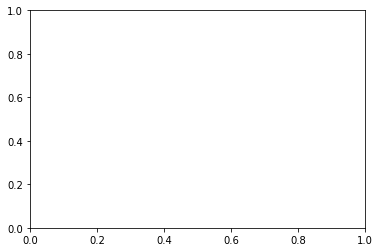

In [23]:
def plot_aop_refl(band_array,
                  refl_extent,
                  colorlimit=(0,1),
                  ax=plt.gca(),
                  title='',
                  cbar ='on',
                  cmap_title='',
                  colormap='Greys'):  
    plot = plt.imshow(band_array,extent=refl_extent,clim=colorlimit); 
    if cbar == 'on':
        cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
        cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

In [24]:
refl,metadata = read_neon_reflh5('../data/NEON_D01_HARV_DP3_732000_4713000_reflectance.h5')

In [25]:
data_clean,metadata_clean = clean_neon_refl_data(refl,metadata)

In [26]:
print('Raw Data Dimensions:',refl.shape)
print('Cleaned Data Dimensions:',data_clean.shape)

Raw Data Dimensions: (1000, 1000, 426)
Cleaned Data Dimensions: (1000, 1000, 360)


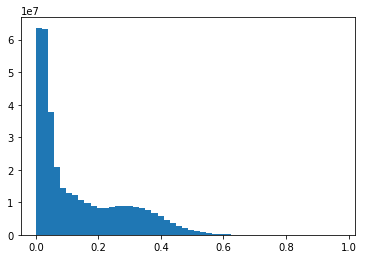

In [27]:
plt.hist(data_clean[data_clean!=-.9999],50);

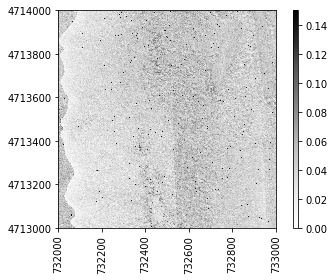

In [38]:
## Plot the cleaned data
plot_aop_refl(data_clean[:,:,0],
              metadata_clean['spatial extent'],
              (0,0.15))

In [29]:
data_clean[0]

array([[0.0446, 0.0285, 0.0211, ..., 0.0265, 0.0223, 0.0185],
       [0.0447, 0.0339, 0.0259, ..., 0.0257, 0.0212, 0.0175],
       [0.0471, 0.0373, 0.0285, ..., 0.0248, 0.0206, 0.0218],
       ...,
       [0.0804, 0.051 , 0.0411, ..., 0.0211, 0.0193, 0.0199],
       [0.0712, 0.0481, 0.0371, ..., 0.0261, 0.0261, 0.0257],
       [0.068 , 0.0491, 0.0295, ..., 0.0269, 0.0251, 0.0255]])

In [30]:
data_clean[data_clean == data_clean[0,0,0]]= np.mean(data_clean[data_clean != data_clean[0,0,0]])
print(np.nanmean(data_clean))
print(data_clean[0])

0.13643932252728988
[[0.13643932 0.0285     0.0211     ... 0.0265     0.0223     0.0185    ]
 [0.0447     0.0339     0.0259     ... 0.0257     0.0212     0.0175    ]
 [0.0471     0.0373     0.0285     ... 0.0248     0.0206     0.0218    ]
 ...
 [0.0804     0.051      0.0411     ... 0.0211     0.0193     0.0199    ]
 [0.0712     0.0481     0.0371     ... 0.0261     0.0261     0.0257    ]
 [0.068      0.0491     0.0295     ... 0.0269     0.0251     0.0255    ]]


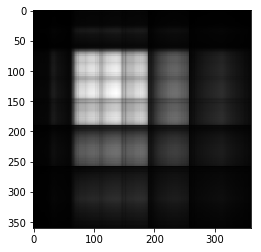

In [31]:
pc = principal_components(data_clean)
pc_view = imshow(pc.cov)
xdata = pc.transform(data_clean)

In the covariance matrix display, whiter values indicate strong positive covariance, darker values indicate strong negative covariance, and grey values indicate covariance near zero.

To reduce dimensionality using principal components, we can sort the eigenvalues in descending order and then retain enough eigenvalues (an corresponding eigenvectors) to capture a desired fraction of the total image variance. We then reduce the dimensionality of the image pixels by projecting them onto the remaining eigenvectors. We will choose to retain a minimum of 99.9% of the total image variance.

55
(1000, 1000, 55)


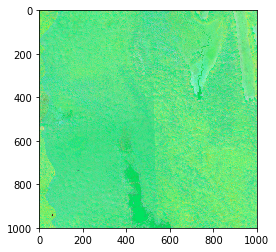

In [32]:
pc_099 = pc.reduce(fraction=0.999)

# How many eigenvalues are left?
print(len(pc_099.eigenvalues))

img_pc = pc_099.transform(data_clean)
print(img_pc.shape)

v = imshow(img_pc[:,:,:5], stretch_all=True)

In [33]:
print(type(img_pc))
print(img_pc.shape)

<class 'numpy.ndarray'>
(1000, 1000, 55)


### Supervised Classification

In [122]:
chm_reshape = np.reshape(tile_1_array,(1000,1000,1))
chm_reshape.shape

(1000, 1000, 1)

In [123]:
stack = np.dstack((img_pc, ENVI_Indices, chm_reshape))

In [124]:
stack.shape

(1000, 1000, 63)

In [125]:
npw=np.asarray(np.where(pixloc_bool==True))
npw.shape

(2, 1255)

In [126]:
Z = stack[npw[0,:],npw[1,:],:]
Z.shape

(1255, 63)

In [127]:
species_classifier = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=2),
    n_estimators=50,
    learning_rate=1.5,
    algorithm="SAMME")

In [131]:
scf = species_classifier.fit(X,response)

ValueError: Found input variables with inconsistent numbers of samples: [1000, 1387]